In [1]:
import librosa
from strechableNumpyArray import StrechableNumpyArray
import numpy as np
import os

pathToBaseDatasetFolder = 'sc09/'
folderNames = ['train']#, 'test', 'valid']
dirs = [pathToBaseDatasetFolder+folderName for folderName in folderNames]
audios = StrechableNumpyArray()
i = 0
total = 0
print('start')
for directory in dirs:
    print(directory)
    for file_name in os.listdir(directory):
        if file_name.endswith('.wav'):      
            audio, sr = librosa.load(directory + '/' + file_name, sr=None, dtype=np.float64)

            if len(audio) < 16000:
                before = int(np.floor((16000-len(audio))/2))
                after = int(np.ceil((16000-len(audio))/2))
                audio = np.pad(audio, (before, after), 'constant', constant_values=(0, 0))
            if len(audio) > 16000: 
                print(file_name, "is too long: ", len(audio))
            if np.sum(np.absolute(audio)) < len(audio)*1e-4: 
                print(file_name, "doesn't meet the minimum amplitude requirement")
                continue

            audios.append(audio[:16000])
            i+=1

            if i > 1000:
                i -= 1000
                total += 1000
                print("1000 plus!", total)
print("there were:", total+i)

audios = audios.finalize()
print (audios.shape)
audios = np.reshape(audios, (total+i, len(audio))).astype(np.float64)
print("audios shape:", audios.shape)


start
sc09/train
1000 plus! 1000
Zero_d90b4138_nohash_2.wav doesn't meet the minimum amplitude requirement
Zero_e96a5020_nohash_0.wav doesn't meet the minimum amplitude requirement
Zero_e96a5020_nohash_1.wav doesn't meet the minimum amplitude requirement
Zero_e96a5020_nohash_2.wav doesn't meet the minimum amplitude requirement
1000 plus! 2000
1000 plus! 3000
One_dea820ce_nohash_1.wav doesn't meet the minimum amplitude requirement
One_e96a5020_nohash_0.wav doesn't meet the minimum amplitude requirement
One_e96a5020_nohash_1.wav doesn't meet the minimum amplitude requirement
One_e96a5020_nohash_2.wav doesn't meet the minimum amplitude requirement
1000 plus! 4000
Two_51055bda_nohash_4.wav doesn't meet the minimum amplitude requirement
Two_712e4d58_nohash_3.wav doesn't meet the minimum amplitude requirement
1000 plus! 5000
Two_e96a5020_nohash_0.wav doesn't meet the minimum amplitude requirement
Two_e96a5020_nohash_1.wav doesn't meet the minimum amplitude requirement
Two_e96a5020_nohash_2.w

In [6]:
from IPython.display import display, Audio

for i in range(0, audios.shape[0], audios.shape[0]//10):
    display(Audio(audios[i], rate=16000))

In [2]:
from ourLTFATStft import LTFATStft
import ltfatpy
from modGabPhaseGrad import modgabphasegrad
ltfatpy.gabphasegrad = modgabphasegrad # This function is not implemented for one sided stfts with the phase method on ltfatpy

fft_hop_size = 128
fft_window_length = 512
L = 16384
clipBelow = -10

anStftWrapper = LTFATStft()
spectrograms = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
tgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
fgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
print(spectrograms.shape)
gs = {'name': 'gauss', 'M': 512}
    
for index, audio in enumerate(audios):
    realDGT = anStftWrapper.oneSidedStft(signal=audio, windowLength=fft_window_length, hopSize=fft_hop_size)
    spectrogram = anStftWrapper.logMagFromRealDGT(realDGT, clipBelow=np.e**clipBelow, normalize=True)
    spectrograms[index] = spectrogram  
    tgradreal, fgradreal = ltfatpy.gabphasegrad('phase', np.angle(realDGT), fft_hop_size,
                                                fft_window_length)
    tgrads[index] = tgradreal /64
    fgrads[index] = fgradreal /256


ModuleNotFoundError: No module named 'ltfatpy'

In [4]:
import scipy.io

nameForFile = 'test_spectrograms_and_derivs'

print(spectrogram.max())
print(spectrogram.min())
print(spectrogram.mean())

shiftedSpectrograms = spectrograms/(-clipBelow/2)+1
print(shiftedSpectrograms.max())
print(shiftedSpectrograms.min())
print(shiftedSpectrograms.mean())

countPerFile = 4000 # mat files sadly cannot be arbitrarily large. 4000 works for 3 matrices (mag+tderiv+fderiv).

for index in range(1 + len(spectrograms)//countPerFile):
    scipy.io.savemat(nameForFile + '_' + str(index+1) + '.mat', dict(logspecs=shiftedSpectrograms[index*countPerFile:(index+1)*countPerFile], 
                                                               tgrad=tgrads[index*countPerFile:(index+1)*countPerFile], 
                                                               fgrad=fgrads[index*countPerFile:(index+1)*countPerFile]))


0.0
-10.0
-6.929828097665495
1.0
-1.0
-0.5086982442073454


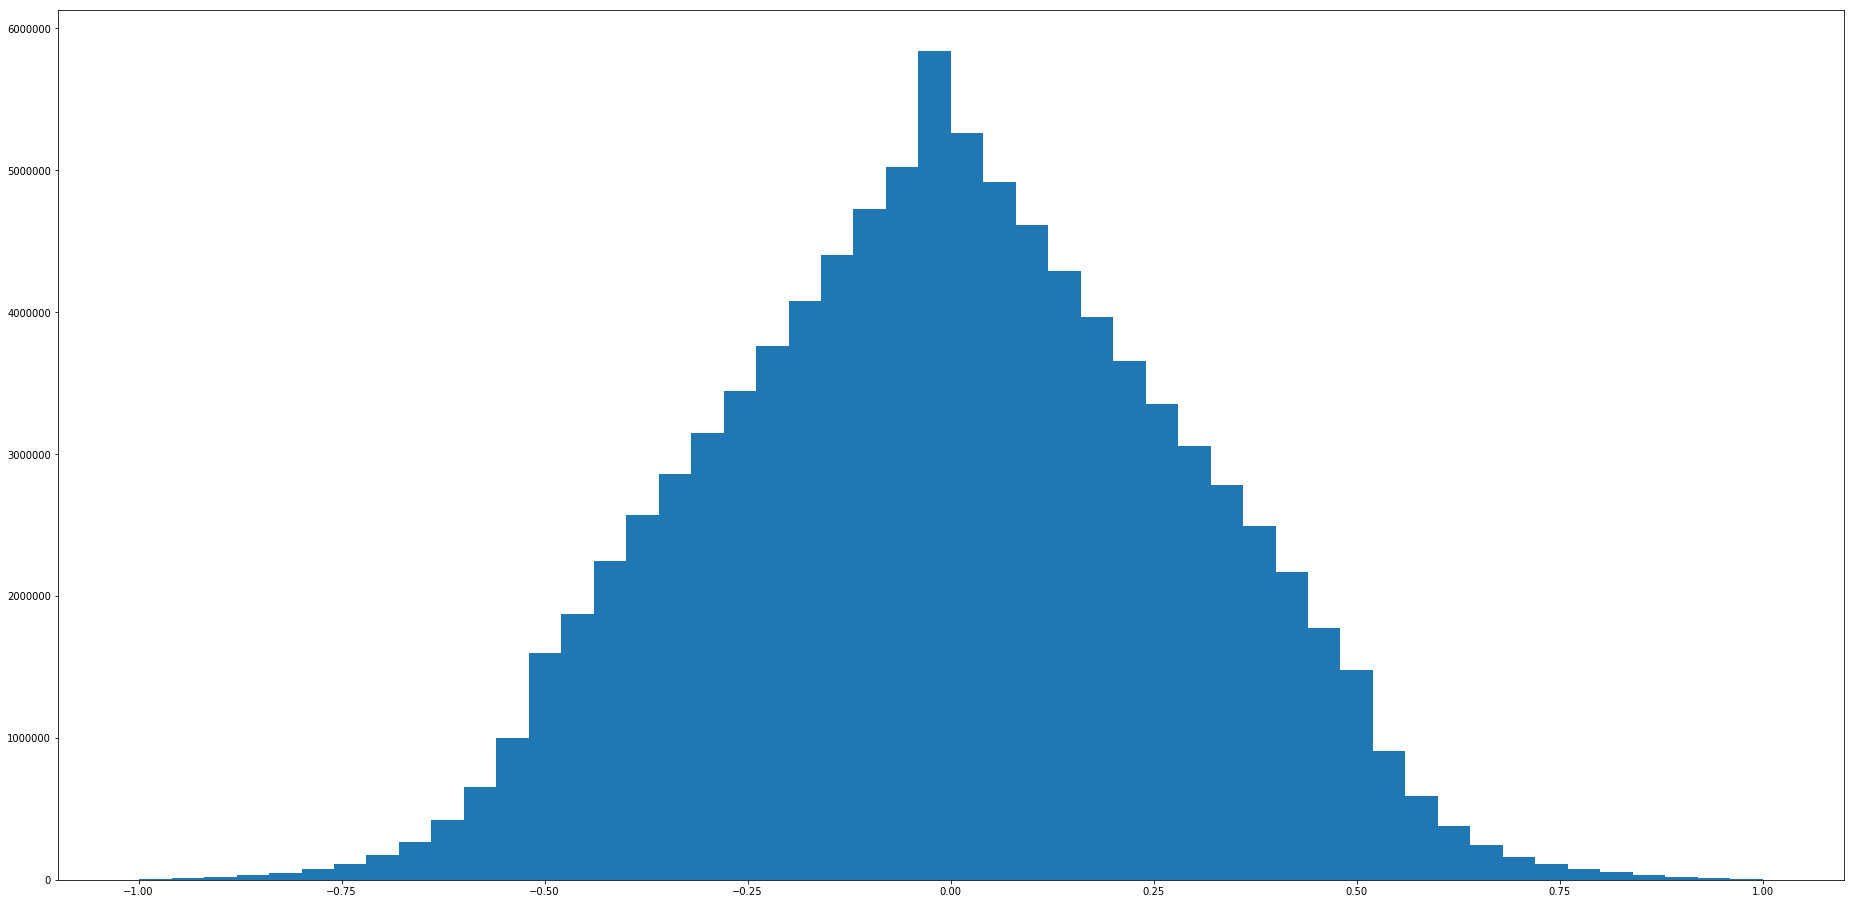

In [5]:
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (32, 16)

plt.hist(tgrads[:10000].flatten(), 50);

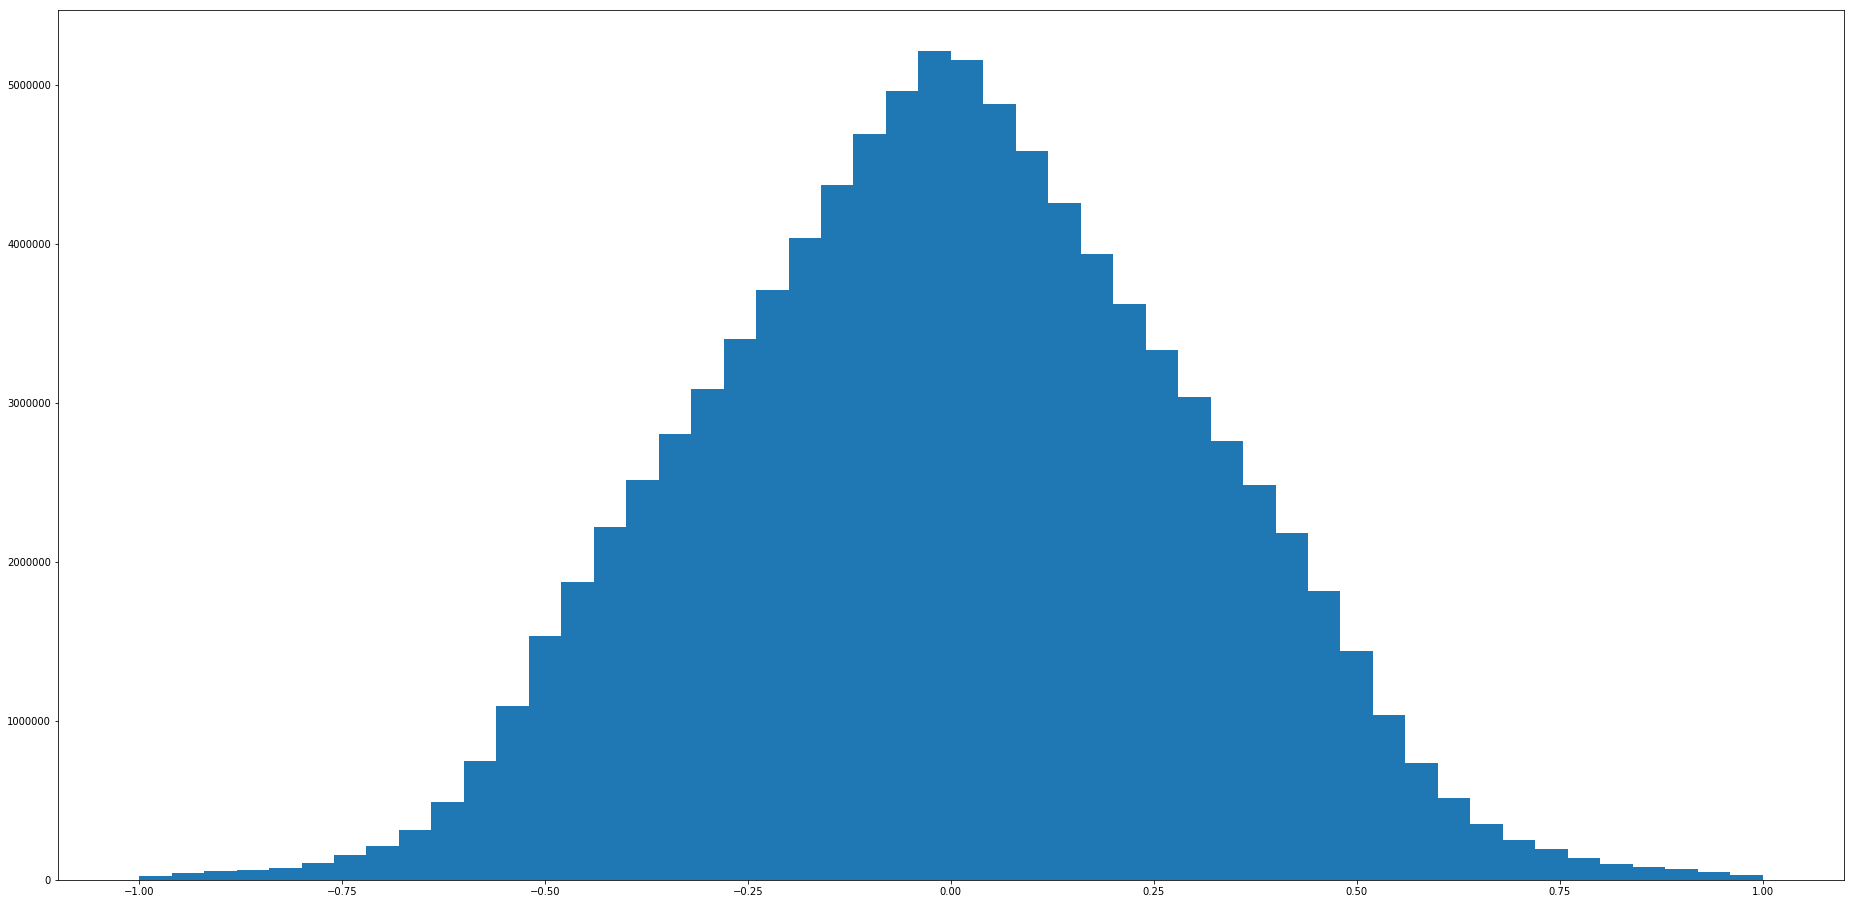

In [6]:
plt.hist(fgrads[:10000].flatten(), 50);

-0.5014453276712592
-1.0
1.0
0.0


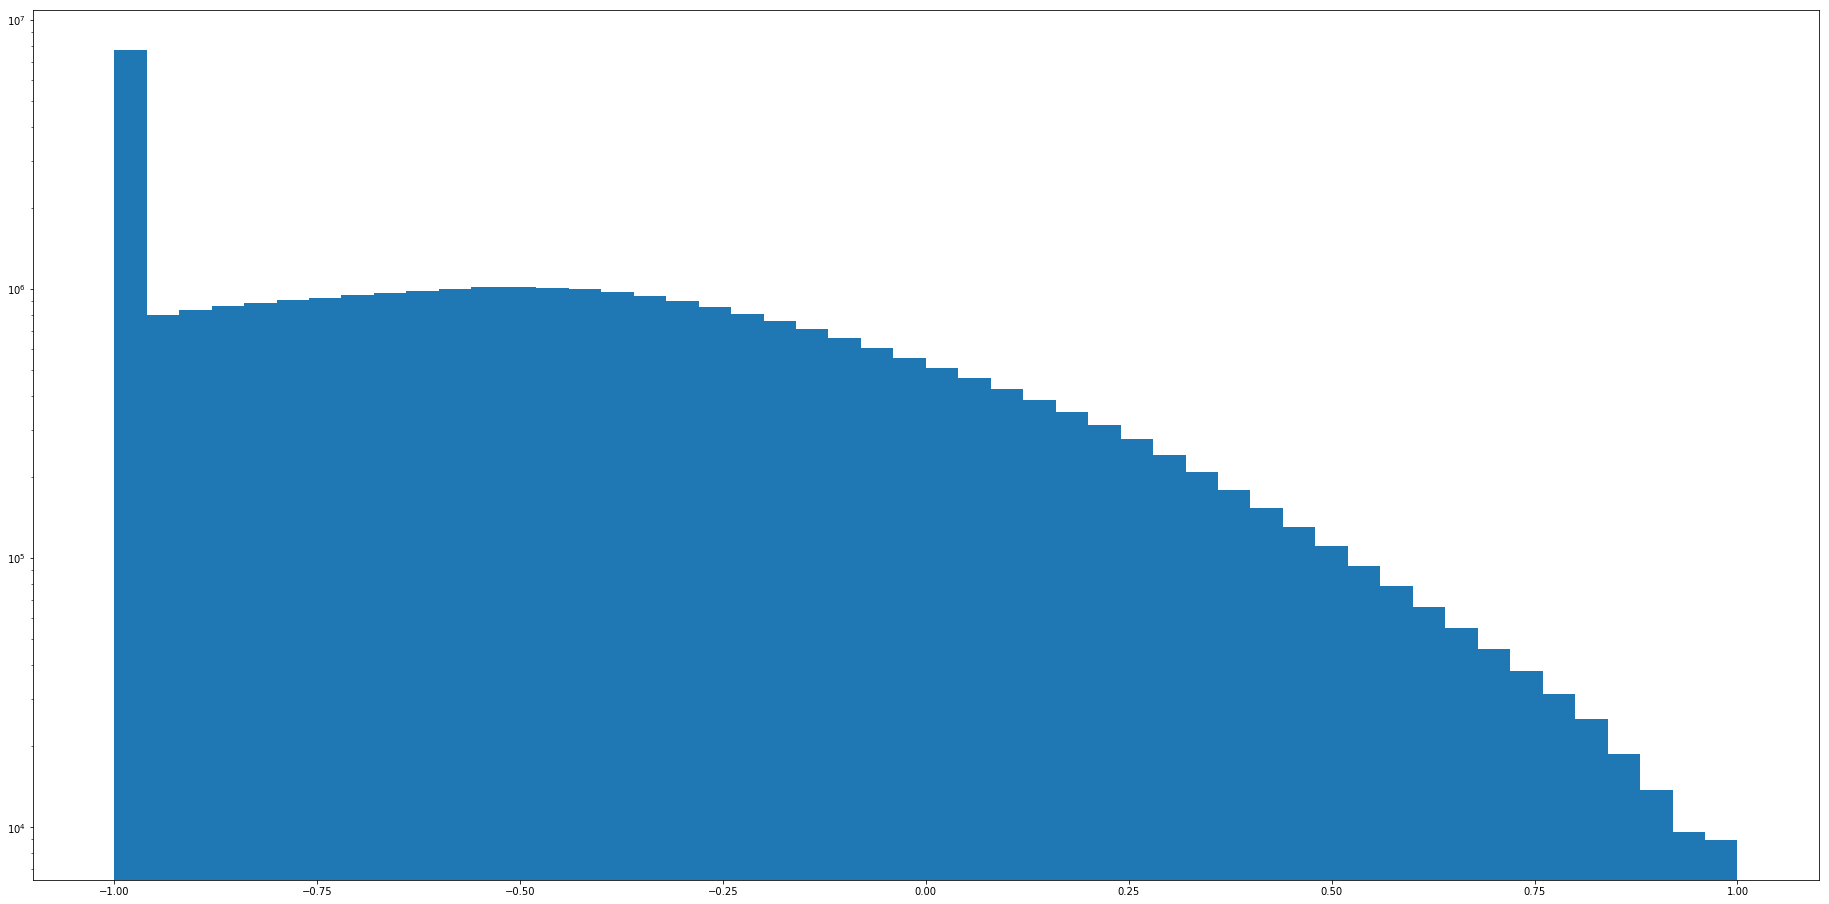

In [7]:
shiftedSpectrograms = spectrograms/5+1
print(np.mean(shiftedSpectrograms))
print(np.min(shiftedSpectrograms))
print(np.max(shiftedSpectrograms))

print(np.max(spectrogram))

plt.hist(shiftedSpectrograms[:1000].flatten(), 50);

plt.yscale('log', nonposy='clip')

In [43]:
"""Alternatively, compute the derivs with the dgt method"""

# from ourLTFATStft import LTFATStft
# import ltfatpy

# anStftWrapper = LTFATStft()
# spectrograms = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
# tgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
# fgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
# print(spectrograms.shape)
# gs = {'name': 'gauss', 'M': 512}
# L = 16384
    
# for index, audio in enumerate(audios):
#     realDGT = anStftWrapper.oneSidedStft(signal=audio, windowLength=fft_window_length, hopSize=fft_hop_size)
#     spectrogram = anStftWrapper.logMagFromRealDGT(realDGT, clipBelow=np.e**-10, normalize=True)
#     spectrograms[index] = spectrogram  
#     tdgtgrad, fdgtgrad, c = ltfatpy.gabphasegrad('dgt', audio, gs, 128, 512, L=L)
#     tgrads[index] = tdgtgrad[:int(fft_window_length//2+1)]
#     fgrads[index] = fdgtgrad[:int(fft_window_length//2+1)]


(23595, 257, 128)
